In [16]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from pathlib import Path
import pathlib  # for typehinting puprose
import requests
from PIL import Image
from typing import Optional

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    #################################################################################
    # -q, --quiet                 Give less output. Option is additive, and can be  #
    #                           used up to 3 times (corresponding to WARNING,       #
    #                           ERROR, and CRITICAL logging levels).                #
    #################################################################################
    from torchinfo import summary


[INFO] Couldn't find torchinfo... installing it.


In [17]:
device = 'cude' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [18]:
# CONSTANTS
IMG_SIZE = 224
PATCH_SIZE = 16

In [19]:
# Initialize paths to download a cat image

data_path = Path('./data')
image_path = data_path / 'cat_image.jpg'

In [20]:
# Download an image to use throughout the model implementation.
def download_image(data_path: pathlib.PosixPath = None,
                   image_path: pathlib.PosixPath = None) -> Optional[int]:

    if not (data_path and image_path):
        print(print(f'[INFO] "data_path and image_path must be specified'))
        return 0

    data_path = data_path
    image_path = image_path

    if data_path.is_dir():
        print(f'[INFO] "{data_path}" directory already exists')
    else:
        print(f'[INFO] "{data_path}" directory does not exist, lets create one...')
        data_path.mkdir(parents=True, exist_ok=True)

    if image_path.is_file():
        print(f'[INFO] "{image_path}" image is already downloaded')
    else:
        print(f'[INFO] Downloading cat image...')
        with open(image_path, 'wb') as f:
            raw_image = requests.get('https://github.com/nikifori/Vit-Paper-Replication/blob/main/images/calm-cat-1-1.jpg?raw=true')
            f.write(raw_image.content)

download_image(data_path=data_path,
               image_path=image_path)

[INFO] "data" directory does not exist, lets create one...
[INFO] Downloading cat image...


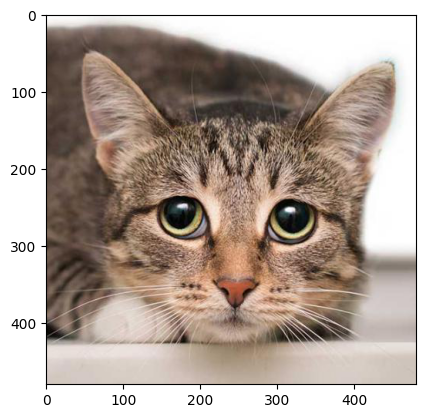

In [21]:
# Show image
cat_image = Image.open(image_path)

plt.imshow(cat_image)

In [22]:
# Preprocess image for compatibility (ViT resolution is 224x224)
manual_transformation = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                           transforms.ToTensor()])

print(manual_transformation)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [23]:
# Transform cat_image
cat_image_transformed = manual_transformation(cat_image)
print(cat_image_transformed.shape)  # (Channels, IMG_SIZE, IMG_SIZE)

# plt.imshow(cat_image_transformed.permute(1, 2, 0))  # permute in order to match matplotlib template

# Add one more dimension as batch dim.
cat_image_transformed = cat_image_transformed.unsqueeze(0)
print(cat_image_transformed.shape)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [26]:
# Implementation of PatchEmbeddingBlock
class PatchEmbeddingBlock(nn.Module):
    """
    Transform a 2D input image into 1D learnable embedding.

    Args:
        in_channels (int): Num of color channels, default: 3.
        patch_size (int): 1D size of a patch, default: 16.
        embedding_dim (int): Constant latent vector size D, default to 768.
    """
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768):

        super().__init__()
        self.patch_size = patch_size    # variable to use in forward method

        self.patchifier = nn.Conv2d(in_channels=in_channels,
                                    out_channels=embedding_dim,
                                    kernel_size=patch_size,
                                    stride=patch_size,
                                    padding=0)

        self.flatten = nn.Flatten(start_dim=-2,
                                  end_dim=-1)

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:

        image_resolution = x.shape[-1]

        assert image_resolution % self.patch_size == 0, f"Input image size must be divisable by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        return self.flatten(self.patchifier(x)).transpose(-2, -1)

In [27]:
patchifier = PatchEmbeddingBlock()
patch_image = patchifier(cat_image_transformed)
print(patch_image.shape)

torch.Size([1, 196, 768])


In [28]:
# Implementation of Multi-Head Attention block with Layer Norm using torch.nn.MultiheadAttention from paper "Attention is all you need (https://arxiv.org/abs/1706.03762)"
class MultiHeadAttentionBlock(nn.Module):
    """
    Creates a multi-head self-attention block with a layer norm layer prior to it.

    Args:
        embedding_dim (int): Dimension of MSA output, embed_dim will be split across num_heads, default: 768.
        num_heads (int): Number of heads in the attention block, default: 12.
        attention_dropout (int): Dropout probability in attn_output_weights (scaled-dot product matrix), default to 0.0.
    """
    def __init__(self,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 attention_dropout: float = 0.0):

        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.msa = nn.MultiheadAttention(embed_dim=embedding_dim,
                                         num_heads=num_heads,
                                         dropout=attention_dropout,
                                         batch_first=True)

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:

        x = self.layer_norm(x)
        output, _ = self.msa(query=x,
                             key=x,
                             value=x,
                             need_weights=False)
        return output



In [29]:
# Test MultiHeadAttentionBlock
msa = MultiHeadAttentionBlock()
image_after_msa = msa(patch_image)
print(image_after_msa.shape)

torch.Size([1, 196, 768])


In [30]:
# Implementation of MLP block
class MLPBlock(nn.Module):
    """
    Creates a MLP block.

    Args:
        embedding_dim (int): Dimension of MSA output, embed_dim will be split across num_heads, default: 768.
        hidden_layer_size (int): MLP hidden layers size, default: 3072.
        dropout (int): Dropout probability in MLP (scaled-dot product matrix), default to 0.0.
    """
    def __init__(self,
                 embedding_dim: int = 768,
                 hidden_layer_size: int = 3072,
                 dropout: float = 0.0):

        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(nn.Linear(in_features=embedding_dim,
                                           out_features=hidden_layer_size),
                                 nn.GELU(),
                                 nn.Dropout(p=dropout),
                                 nn.Linear(in_features=hidden_layer_size,
                                           out_features=embedding_dim),
                                 nn.GELU(),
                                 nn.Dropout(p=dropout))

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:

                return self.mlp(self.layer_norm(x))

In [31]:
# Test MLPblock
mlp = MLPBlock()
image_after_mlp = mlp(image_after_msa)
print(image_after_mlp.shape)

torch.Size([1, 196, 768])


In [32]:
# Implement an Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    """
    Creates a MLP block.

    Args:
        embedding_dim (int): Dimension of MSA output, embed_dim will be split across num_heads, default: 768.
        num_heads (int): Number of heads in the attention block, default: 12.
        attention_dropout (int): Dropout probability in attn_output_weights (scaled-dot product matrix), default to 0.0.
        hidden_layer_size (int): MLP hidden layers size, default: 3072.
        dropout (int): Dropout probability in MLP (scaled-dot product matrix), default to 0.0.
    """
    def __init__(self,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 attention_dropout: float = 0.0,
                 hidden_layer_size: int = 3072,
                 dropout: float = 0.0):

        super().__init__()

        self.norm_msa = MultiHeadAttentionBlock(embedding_dim=embedding_dim,
                                                num_heads=num_heads,
                                                attention_dropout=attention_dropout)

        self.norm_mlp = MLPBlock(embedding_dim=embedding_dim,
                                 hidden_layer_size=hidden_layer_size,
                                 dropout=dropout)

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:
                x += self.norm_msa(x)
                x += self.norm_mlp(x)

                return x

In [33]:
# Test TransformerEncoderBlock
trans_enc = TransformerEncoderBlock()
image_after_trans_enc = trans_enc(patch_image)
print(image_after_trans_enc.shape)

torch.Size([1, 196, 768])


In [34]:
class MLPHeadBlock(nn.Module):
    """
    Creates the MLP at the top of the ViT architecture.

    Args:
        embedding_dim (int): Dimension of MSA output, embed_dim will be split across num_heads, default: 768.
        n_classes (int): The number of downstream classes., default: 1000.
    """
    def __init__(self,
                 embedding_dim: int = 768,
                 n_classes: int = 1000):

        super().__init__()
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                        nn.Linear(in_features=embedding_dim,
                                                  out_features=n_classes))

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:

                return self.classifier(x)


In [35]:
# Test MLPHeadBlock
mlp_head_block = MLPHeadBlock()
image_after_mlp_head_block = mlp_head_block(image_after_trans_enc[:, 0])
print(image_after_mlp_head_block.shape)

torch.Size([1, 1000])


In [40]:
# Implement the Vi(sion)T(ransformer)
class ViT(nn.Module):
    """
    TODO

    Args:
        embedding_dim (int): Dimension of MSA output, embed_dim will be split across num_heads, default: 768.
        n_classes (int): The number of downstream classes., default: 1000.
    """
    def __init__(self,
                 img_size:int=224,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 num_transformer_layers:int=12,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 attention_dropout: float = 0.0,
                 hidden_layer_size: int = 3072,
                 dropout: float = 0.0,
                 patchifier_dropout: float = 0.0,
                 n_classes: int = 1000):

        super().__init__()

        assert (img_size % patch_size) == 0 , 'Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}.'
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        self.positional_embeddings = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                                  requires_grad=True)

        self.patch_dropout = nn.Dropout(p=patchifier_dropout)

        self.patch_embedding = PatchEmbeddingBlock(in_channels=in_channels,
                                                   patch_size=patch_size,
                                                   embedding_dim=embedding_dim)

        self.encoders = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                num_heads=num_heads,
                                                                attention_dropout=attention_dropout,
                                                                hidden_layer_size=hidden_layer_size,
                                                                dropout=dropout) for _ in range(num_transformer_layers)])

        self.classifier = MLPHeadBlock(embedding_dim=embedding_dim,
                                       n_classes=n_classes)

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:

                assert ((x.shape[-1] * x.shape[-2]) % self.patch_size * 2) == 0 , f'Image size must be divisible by patch size, image size: {x.shape[-1]}x{x.shape[-2]}, patch size: {self.patch_size}.'

                batch_size = x.shape[0]

                # expand class token equal to batch size
                class_token = self.class_embedding.expand(batch_size, -1, -1)

                # patchify
                x = self.patch_embedding(x)

                # add class token
                x = torch.cat((class_token, x), dim=1, )

                # add positional embeddings
                x += self.positional_embeddings

                # after dense layers apply dropout
                x = self.patch_dropout(x)

                # Pass patch, position and class embedding through transformer encoder layers
                x = self.encoders(x)

                # Pass the CLS token tensor through classifier
                x = self.classifier(x[:, 0])

                return x








In [42]:
# vit for classification with 3 classes and without dropout during training phase
vit = ViT(img_size=224,
          in_channels=3,
          patch_size=16,
          num_transformer_layers=12,
          embedding_dim=768,
          num_heads=12,
          attention_dropout=0.0,
          hidden_layer_size=3072,
          dropout=0.0,
          patchifier_dropout=0.0,
          n_classes=3)

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbeddingBlock (patch_embedding)            [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patchifier)                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                           [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (patch_dropout)                          [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (encoders)                            [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                 [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─MultiHeadAttentionBlock (norm_msa) 